# Covid-19 Forecasting using an RNN

The goal of this notebook is very simple: Generate additional features from the Covid19-global-forecasting dataset and feed it into an RNN. The RNN will take as inputs:
*     number of cases for 13 days
*     number of fatalities for 13 days

as outputs:
*    number of cases for the 14th day
*    number of fatalities for the 14th day

* V5: Submission pipeline fixed - score: 3.09681
* V6: New RNN architecture with two separate branches for each output - score: 2.25901
* V8: Add a post-processing step checking if the model's output is equal or greater the previous value - score: 2.29932
* V9: Change the MSE losses to RMSLE - score: 1.43247
* V11: Change the outputs' activation fucntions from linear to ReLU - score: 1.26594
* V12: Use a 2-week period for predictions instead of 1. Replace the SimpleRNN layers with LSTM layers - score: 1.14070
* V13: Fix bug in Cell 4 (flagged by [@jeremyoudin](https://www.kaggle.com/jeremyoudin)) which made the dataset much larger due to duplicates and also created a leakage between the training and validation sets.
* V15: Start introducing new inputs from the [enriched dataset](https://www.kaggle.com/optimo/covid19-enriched-dataset-week-2) by [@optimo](https://www.kaggle.com/optimo) and fix a bug which prevented the generation of 25% of the training data.

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import os
import tensorflow as tf
from tqdm import tqdm
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from datetime import timedelta

from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/enriched-covid-19-week2/enriched_covid_19_week_2.csv
/kaggle/input/covid19-global-forecasting-week-2/train.csv
/kaggle/input/covid19-global-forecasting-week-2/submission.csv
/kaggle/input/covid19-global-forecasting-week-2/test.csv


In [2]:
train_df = gpd.read_file("/kaggle/input/enriched-covid-19-week2/enriched_covid_19_week_2.csv")
train_df["Country_Region"] = [country_name.replace("'","") for country_name in train_df["Country_Region"]]
train_df["quarantine"] = train_df["quarantine"].astype("int")
train_df["schools"] = train_df["schools"].astype("int")
train_df.head()

,Id,Country_Region,Province_State,Date,ConfirmedCases,Fatalities,age_0-4,age_5-9,age_10-14,age_15-19,...,density,urbanpop,hospibed,lung,femalelung,malelung,restrictions,quarantine,schools,geometry
0,1,Afghanistan,,2020-01-22,0.0,0.0,0.1457166900587929,0.13913315751113053,0.13337619499377074,0.1189222268680805,...,60.0,25.0,0.5,37.62,36.31,39.33,0,0,0,None
1,2,Afghanistan,,2020-01-23,0.0,0.0,0.1457166900587929,0.13913315751113053,0.13337619499377074,0.1189222268680805,...,60.0,25.0,0.5,37.62,36.31,39.33,0,0,0,None
2,3,Afghanistan,,2020-01-24,0.0,0.0,0.1457166900587929,0.13913315751113053,0.13337619499377074,0.1189222268680805,...,60.0,25.0,0.5,37.62,36.31,39.33,0,0,0,None
3,4,Afghanistan,,2020-01-25,0.0,0.0,0.1457166900587929,0.13913315751113053,0.13337619499377074,0.1189222268680805,...,60.0,25.0,0.5,37.62,36.31,39.33,0,0,0,None
4,5,Afghanistan,,2020-01-26,0.0,0.0,0.1457166900587929,0.13913315751113053,0.13337619499377074,0.1189222268680805,...,60.0,25.0,0.5,37.62,36.31,39.33,0,0,0,None


In [3]:
train_df.columns

Index(['Id', 'Country_Region', 'Province_State', 'Date', 'ConfirmedCases',
       'Fatalities', 'age_0-4', 'age_5-9', 'age_10-14', 'age_15-19',
       'age_20-24', 'age_25-29', 'age_30-34', 'age_35-39', 'age_40-44',
       'age_45-49', 'age_50-54', 'age_55-59', 'age_60-64', 'age_65-69',
       'age_70-74', 'age_75-79', 'age_80-84', 'age_85-89', 'age_90-94',
       'age_95-99', 'age_100+', 'total_pop', 'smokers_perc', 'density',
       'urbanpop', 'hospibed', 'lung', 'femalelung', 'malelung',
       'restrictions', 'quarantine', 'schools', 'geometry'],
      dtype='object')

I create a new dataframe where I will only store 6-day trends for each location with the resulting numbers on the 7th day. The time periods extracted do not overlap on purpose.

In [4]:
trend_df = pd.DataFrame(columns={"infection_trend","fatality_trend","quarantine_trend","school_trend","total_population","expected_cases","expected_fatalities"})

In [5]:
#Just getting rid of the first days to have a multiple of 14
#Makes it easier to generate the sequences
train_df = train_df.query("Date>'2020-01-22'and Date<='2020-03-18'")
days_in_sequence = 14

trend_list = []

with tqdm(total=len(list(train_df.Country_Region.unique()))) as pbar:
    for country in train_df.Country_Region.unique():
        for province in train_df.query(f"Country_Region=='{country}'").Province_State.unique():
            province_df = train_df.query(f"Country_Region=='{country}' and Province_State=='{province}'")
            for i in range(0,len(province_df),days_in_sequence):
                
                infection_trend = [float(x) for x in province_df[i:i+days_in_sequence-1].ConfirmedCases.values]
                fatality_trend = [float(x) for x in province_df[i:i+days_in_sequence-1].Fatalities.values]
                quarantine_trend = [float(x) for x in province_df[i:i+days_in_sequence-1].quarantine.values]
                school_trend = [float(x) for x in province_df[i:i+days_in_sequence-1].schools.values]
                total_population = float(province_df.iloc[i].total_pop)
                expected_cases = float(province_df.iloc[i+days_in_sequence-1].ConfirmedCases)
                expected_fatalities = float(province_df.iloc[i+days_in_sequence-1].Fatalities)

                trend_list.append({"infection_trend":infection_trend,
                                 "fatality_trend":fatality_trend,
                                 "quarantine_trend":quarantine_trend,
                                 "school_trend":school_trend,
                                 "total_population":total_population,
                                 "expected_cases":expected_cases,
                                 "expected_fatalities":expected_fatalities})
        pbar.update(1)
trend_df = pd.DataFrame(trend_list)

100%|██████████| 294/294 [00:09<00:00, 31.53it/s]


Shuffling the dataframe to make sure we have a bit of everything in our training and validation set.

In [6]:
trend_df["input"] = [np.asarray([trends["infection_trend"],trends["fatality_trend"],trends["quarantine_trend"],trends["school_trend"]]) for idx,trends in trend_df.iterrows()]

In [7]:
trend_df = shuffle(trend_df)
trend_df.head()

,infection_trend,fatality_trend,quarantine_trend,school_trend,total_population,expected_cases,expected_fatalities,input
205,"[411.0, 426.0, 428.0, 468.0, 486.0, 505.0, 518...","[2.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3.0, 4.0, 5.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1439323.774,560.0,5.0,"[[411.0, 426.0, 428.0, 468.0, 486.0, 505.0, 51..."
495,"[31.0, 45.0, 46.0, 73.0, 73.0, 89.0, 99.0, 99....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",10423.056,418.0,5.0,"[[31.0, 45.0, 46.0, 73.0, 73.0, 89.0, 99.0, 99..."
361,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",10708.982,0.0,0.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
70,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",10139.175,3.0,0.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
128,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",20903.278,0.0,0.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


Only keeping 2000 sequences where the number of cases stays at 0, as there were way too many of these samples in our dataset.

In [8]:
i=0
y=0
temp_df = pd.DataFrame(columns={"infection_trend","fatality_trend","expected_cases","expected_fatalities","input"})
for idx,row in trend_df.iterrows():
    if sum(row.infection_trend)>0:
        temp_df = temp_df.append(row)
    else:
        if i<50:
            temp_df = temp_df.append(row)
            i+=1
trend_df = temp_df

In [9]:
trend_df[:20]

,fatality_trend,input,infection_trend,expected_fatalities,expected_cases,quarantine_trend,school_trend,total_population
205,"[2.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3.0, 4.0, 5.0, ...","[[411.0, 426.0, 428.0, 468.0, 486.0, 505.0, 51...","[411.0, 426.0, 428.0, 468.0, 486.0, 505.0, 518...",5.0,560.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1439323.774
495,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, ...","[[31.0, 45.0, 46.0, 73.0, 73.0, 89.0, 99.0, 99...","[31.0, 45.0, 46.0, 73.0, 73.0, 89.0, 99.0, 99....",5.0,418.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",10423.056
361,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",10708.982
70,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,3.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",10139.175
128,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",20903.278
48,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,2.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",25499.881
583,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",0.0,3.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",53771.300
568,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[2.0, 2.0, 2.0, 4.0, 4.0, 7.0, 7.0, 11.0, 15....","[2.0, 2.0, 2.0, 4.0, 4.0, 7.0, 7.0, 11.0, 15.0...",0.0,22.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",126476.458
595,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,3.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",6524.191
615,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",6871.287


Splitting my dataset - 90% for training and 10% for validation

In [10]:
sequence_length = 13
training_percentage = 0.9

In [11]:
training_item_count = int(len(trend_df)*training_percentage)
validation_item_count = len(trend_df)-int(len(trend_df)*training_percentage)
training_df = trend_df[:training_item_count]
validation_df = trend_df[training_item_count:]

In [12]:
X_train = np.asarray(np.reshape(np.asarray([np.asarray(x) for x in training_df["input"].values]),(training_item_count,4,sequence_length))).astype(np.float32)
Y_cases_train = np.asarray([np.asarray(x) for x in training_df["expected_cases"]]).astype(np.float32)
Y_fatalities_train = np.asarray([np.asarray(x) for x in training_df["expected_fatalities"]]).astype(np.float32)

In [13]:
X_test = np.asarray(np.reshape(np.asarray([np.asarray(x) for x in validation_df["input"]]),(validation_item_count,4,sequence_length))).astype(np.float32)
Y_cases_test = np.asarray([np.asarray(x) for x in validation_df["expected_cases"]]).astype(np.float32)
Y_fatalities_test = np.asarray([np.asarray(x) for x in validation_df["expected_fatalities"]]).astype(np.float32)

## Build the model

The model is very simple in terms of architecture. The only difference from what could traditionally be seen is that it has two outputs so we can have two different losses (one for the expected number of cases and for the expected number of fatalities).

In [14]:

input_layer = Input(shape=(4,sequence_length))
main_rnn_layer = layers.LSTM(128, return_sequences=True, recurrent_dropout=0.2)(input_layer)

rnn_c = layers.LSTM(64)(main_rnn_layer)
rnn_f = layers.LSTM(64)(main_rnn_layer)

dense_c = layers.Dense(256)(rnn_c)
dropout_c = layers.Dropout(0.3)(dense_c)

dense_f = layers.Dense(256)(rnn_f)
dropout_f = layers.Dropout(0.3)(dense_f)

cases = layers.Dense(1, activation="relu",name="cases")(dropout_c)
fatalities = layers.Dense(1, activation="relu", name="fatalities")(dropout_f)
model = Model(input_layer, [cases,fatalities])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 4, 13)]      0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 4, 128)       72704       input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 64)           49408       lstm[0][0]                       
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 64)           49408       lstm[0][0]                       
______________________________________________________________________________________________

In [15]:
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=4, verbose=1, factor=0.7),
             EarlyStopping(monitor='val_loss', patience=20),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]
model.compile(loss=[tf.keras.losses.MeanSquaredLogarithmicError(),tf.keras.losses.MeanSquaredLogarithmicError()], optimizer='adam')

In [16]:
history = model.fit(X_train, [Y_cases_train, Y_fatalities_train], 
          epochs = 200, 
          batch_size = 16, 
          validation_data=(X_test,  [Y_cases_test, Y_fatalities_test]), 
          callbacks=callbacks)

Train on 495 samples, validate on 55 samples
Epoch 1/200
495/495 [==============================] - 7s 14ms/sample - loss: 7.6705 - cases_loss: 6.6692 - fatalities_loss: 0.9920 - val_loss: 6.3972 - val_cases_loss: 4.4150 - val_fatalities_loss: 1.4171
Epoch 2/200
495/495 [==============================] - 0s 973us/sample - loss: 3.1407 - cases_loss: 2.5722 - fatalities_loss: 0.5663 - val_loss: 4.4854 - val_cases_loss: 3.0016 - val_fatalities_loss: 0.9940
Epoch 3/200
495/495 [==============================] - 0s 965us/sample - loss: 2.1902 - cases_loss: 1.7963 - fatalities_loss: 0.3917 - val_loss: 3.7187 - val_cases_loss: 2.3678 - val_fatalities_loss: 0.9261
Epoch 4/200
495/495 [==============================] - 0s 981us/sample - loss: 1.8008 - cases_loss: 1.4423 - fatalities_loss: 0.3561 - val_loss: 3.3049 - val_cases_loss: 2.0271 - val_fatalities_loss: 0.8708
Epoch 5/200
495/495 [==============================] - 0s 974us/sample - loss: 1.5871 - cases_loss: 1.2318 - fatalities_loss: 0.

## Performance during training

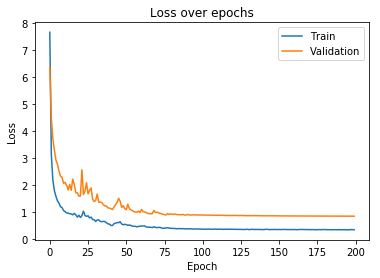

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

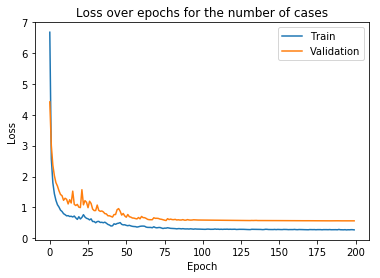

In [18]:
plt.plot(history.history['cases_loss'])
plt.plot(history.history['val_cases_loss'])
plt.title('Loss over epochs for the number of cases')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

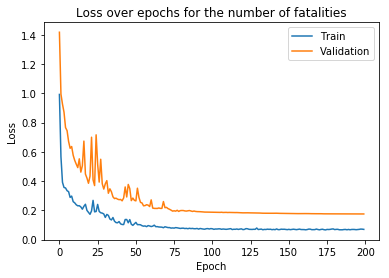

In [19]:
plt.plot(history.history['fatalities_loss'])
plt.plot(history.history['val_fatalities_loss'])
plt.title('Loss over epochs for the number of fatalities')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

## Generate predictions using the model

We can quickly check the quality of the predictions... One thing is clear, there is room for improvement!

In [20]:
model.load_weights("best_model.h5")

In [21]:
predictions = model.predict(X_test)

In [22]:
display_limit = 30
for inputs, pred_cases, exp_cases, pred_fatalities, exp_fatalities in zip(X_test,predictions[0][:display_limit], Y_cases_test[:display_limit], predictions[1][:display_limit], Y_fatalities_test[:display_limit]):
    print("================================================")
    print(inputs)
    print("Expected cases:", exp_cases, " Prediction:", pred_cases[0], "Expected fatalities:", exp_fatalities, " Prediction:", pred_fatalities[0] )

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Expected cases: 1.0  Prediction: 1.1970385 Expected fatalities: 0.0  Prediction: 0.0
[[12. 13. 13. 14. 14. 16. 16. 16. 16. 16. 16. 16. 16.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
Expected cases: 16.0  Prediction: 19.252213 Expected fatalities: 0.0  Prediction: 0.0
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Expected cases: 2.0  Prediction: 1.1970385 Expected fatalities: 0.0  Prediction: 0.0
[[0. 0. 0. 3. 4. 4. 4. 4. 4. 4. 4. 4. 4.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Expected cases: 

### Apply the model on this existing data

The following functions will be used to get the 6 previous days from a given date, predict the number of cases and fatalities, before iterating again. Therefore, it will use the prediction for the next day as part of the data for the one afterwards.

In [23]:
#Will retrieve the number of cases and fatalities for the past 6 days from the given date
def build_inputs_for_date(country, province, date, df):
    start_date = date - timedelta(days=13)
    end_date = date - timedelta(days=1)
    
    str_start_date = start_date.strftime("%Y-%m-%d")
    str_end_date = end_date.strftime("%Y-%m-%d")
    df = df.query("Country_Region=='"+country+"' and Province_State=='"+province+"' and Date>='"+str_start_date+"' and Date<='"+str_end_date+"'")
    input_data = np.reshape(np.asarray([df["ConfirmedCases"],df["Fatalities"],df["quarantine"],df["schools"]]),(4,sequence_length)).astype(np.float32)
    
    return input_data

In [24]:
#Take a dataframe in input, will do the predictions and return the dataframe with extra rows
#containing the predictions
def predict_for_region(country, province, df):
    begin_prediction = "2020-03-19"
    start_date = datetime.strptime(begin_prediction,"%Y-%m-%d")
    end_prediction = "2020-04-30"
    end_date = datetime.strptime(end_prediction,"%Y-%m-%d")
    
    date_list = [start_date + timedelta(days=x) for x in range((end_date-start_date).days+1)]
    for date in date_list:
        input_data = build_inputs_for_date(country, province, date, df)
        result = model.predict(np.array([input_data]))
        
        #just ensuring that the outputs is above 0
        # or higher than the previous counts
        #Get the absolute value for the number of cases
        
        result[0] = np.round(result[0])
        if result[0]<input_data[0][-1]:
            result[0]=np.array([[input_data[0][-1]]])
        
        result[1] = np.round(result[1])
        if result[1]<input_data[1][-1]:
            result[1]=np.array([[input_data[1][-1]]])
            
        #We assign the quarantine and school status
        #depending on previous values
        #e.g Once a country is locked, it will stay locked until the end
        df = df.append({"Country_Region":country, 
                        "Province_State":province, 
                        "Date":date.strftime("%Y-%m-%d"), 
                        "quarantine": 1 if any(input_data[2]) else 0,
                        "schools": 1 if any(input_data[3]) else 0,
                        "ConfirmedCases":round(result[0][0][0]),	
                        "Fatalities":round(result[1][0][0])},
                       ignore_index=True)
    return df

In [25]:
copy_df = train_df
with tqdm(total=len(list(copy_df.Country_Region.unique()))) as pbar:
    for country in copy_df.Country_Region.unique():
        for province in copy_df.query("Country_Region=='"+country+"'").Province_State.unique():
            copy_df = predict_for_region(country, province, copy_df)
        pbar.update(1)

100%|██████████| 294/294 [44:46<00:00,  9.14s/it]


Example

In [26]:
copy_df.query("Country_Region=='France_French Guiana' and Date>'2020-03-19'")

,Id,Country_Region,Province_State,Date,ConfirmedCases,Fatalities,age_0-4,age_5-9,age_10-14,age_15-19,...,density,urbanpop,hospibed,lung,femalelung,malelung,restrictions,quarantine,schools,geometry
21109,NaN,France_French Guiana,French Guiana,2020-03-20,12,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,None
21110,NaN,France_French Guiana,French Guiana,2020-03-21,14,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,None
21111,NaN,France_French Guiana,French Guiana,2020-03-22,15,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,None
21112,NaN,France_French Guiana,French Guiana,2020-03-23,17,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,None
21113,NaN,France_French Guiana,French Guiana,2020-03-24,20,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,None
21114,NaN,France_French Guiana,French Guiana,2020-03-25,23,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,None
21115,NaN,France_French Guiana,French Guiana,2020-03-26,26,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,None
21116,NaN,France_French Guiana,French Guiana,2020-03-27,27,1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,None
21117,NaN,France_French Guiana,French Guiana,2020-03-28,30,2,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,None
21118,NaN,France_French Guiana,French Guiana,2020-03-29,38,3,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,None


In [27]:
test_df = gpd.read_file("/kaggle/input/covid19-global-forecasting-week-2/test.csv")
#The country_region got modifying in the enriched dataset by @optimo, 
# so we have to apply the same change to the test Dataframe.
test_df["Country_Region"] = [ row.Country_Region if row.Province_State=="" else row.Country_Region+"_"+row.Province_State for idx,row in test_df.iterrows() ]
test_df.head()

,ForecastId,Province_State,Country_Region,Date,geometry
0,1,,Afghanistan,2020-03-19,None
1,2,,Afghanistan,2020-03-20,None
2,3,,Afghanistan,2020-03-21,None
3,4,,Afghanistan,2020-03-22,None
4,5,,Afghanistan,2020-03-23,None


Just need to do this little trick to extract the relevant date and the forecastId and add that to the submission file.

In [28]:
submission_df = pd.DataFrame(columns=["ForecastId","ConfirmedCases","Fatalities"])
with tqdm(total=len(test_df)) as pbar:
    for idx, row in test_df.iterrows():
        #Had to remove single quotes because of countries like Cote D'Ivoire for example
        country_region = row.Country_Region.replace("'","").strip(" ")
        province_state = row.Province_State.replace("'","").strip(" ")
        item = copy_df.query("Country_Region=='"+country_region+"' and Province_State=='"+province_state+"' and Date=='"+row.Date+"'")
        submission_df = submission_df.append({"ForecastId":row.ForecastId,
                                              "ConfirmedCases":int(item.ConfirmedCases.values[0]),
                                              "Fatalities":int(item.Fatalities.values[0])},
                                             ignore_index=True)
        pbar.update(1)

100%|██████████| 12642/12642 [03:53<00:00, 54.25it/s]


In [29]:
submission_df.sample(20)

,ForecastId,ConfirmedCases,Fatalities
768,769,156,1
1268,1269,765,23
7253,7254,211,0
10443,10444,438,1
543,544,473,0
550,551,473,0
2666,2667,67800,3122
5311,5312,764,131
4715,4716,243,0
10972,10973,267,5


In [30]:
submission_df.to_csv("submission.csv",index=False)

### Of course, this notebook still requires a lot of work but I thought I would release a first version anyway, mainly to help anyone who could be working on a similar pipeline. I will try to update this notebook with an improved model itself and some charts to better understand our outputs in the following iterations.

### If you found this notebook helpful, please give it an upvote. It will be greatly appreciated!